# CAPSTONE PROJECT
## GROUP TWARB
### MEMBERS: Austin Kanja, Benson Ouma,  Rahab Gachie, Ted Ronoh & Winnie Odoyo
### Title: IN VEHICLE COUPON RECOMMENDATION SYSTEM

The data set has been sourced from UC Irvine Machine Learning Repository https://archive.ics.uci.edu/datasets/
The dataset contains 12,684 records and 26 features, including:
- Demographic information: gender, age, marital Status, education, income
- Contextual data: weather, temperature, time, destination, passanger
- Behavioral indicators: frequency of visiting Bar, Coffee-house, Restaurant Less Than 20, etc.
- Response variable: Y ()

#### LOADING THE DATA
Importing the libraries that will be used through out the project.


In [1]:
import pandas as pd   
import numpy as np  
import zipfile
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# extract the files
zip_path = 'in+vehicle+coupon+recommendation.zip'

extract_dir = 'unzipped/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    
    zip_ref.extractall(extract_dir)
    print(f"Files extracted to {extract_dir}")
    
    print("Files in the zip archive:")
    for file in zip_ref.namelist():
        print(file)

Files extracted to unzipped/
Files in the zip archive:
in-vehicle-coupon-recommendation.csv


In [3]:
# Load the dataset
df = pd.read_csv('unzipped\in-vehicle-coupon-recommendation.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


##### Check for missing values

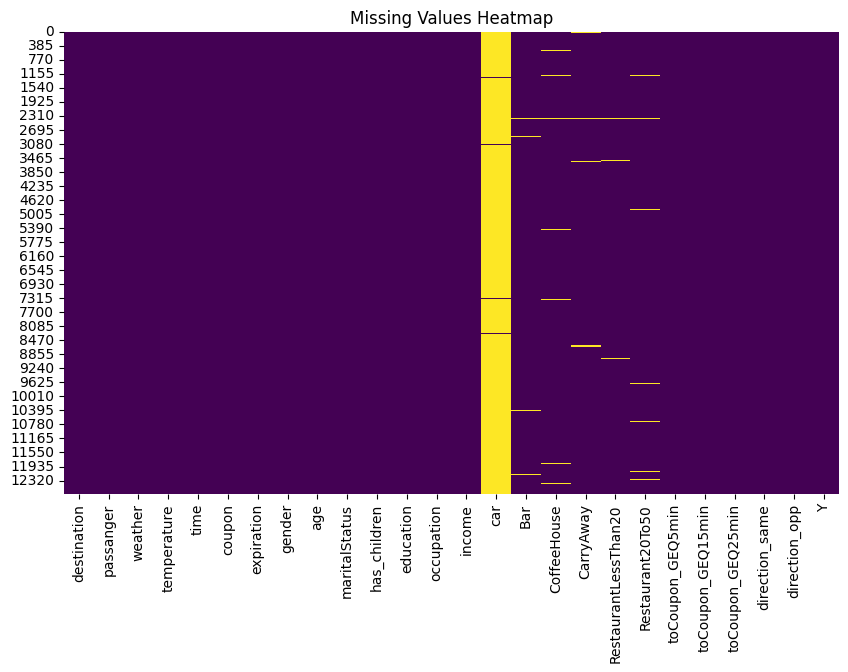

In [6]:
# check for missing values
df.isnull().sum()

# visualize the missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

From the above visualization, the car column has excessive missing values (99%). The ideal way of handling this is by dropping the column.
##### Handling Missing Values

In [7]:
# drop car column
df_cleaned = df.drop(columns=['car'])

# For categorical columns with few missing values we fill with mode
cat_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# For numerical columns we fill with median
num_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Check if any missing values remain
print(df_cleaned.isnull().sum().sum())

0


In [11]:
print(num_cols)
print(cat_cols)

Index(['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y'],
      dtype='object')
Index(['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50'],
      dtype='object')


##### Check for duplicate rows

In [ ]:
print(f"Number of duplicate rows: {df_cleaned.duplicated().sum()}")

Number of duplicate rows: 74


In [17]:
# remove the duplicate rows
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
duplicates_removed = initial_rows - len(df_cleaned)
print(f"✓ Removed {duplicates_removed} duplicate rows")


✓ Removed 74 duplicate rows


Correct the typo in 'passanger' to 'passenger'

In [18]:
df_cleaned = df_cleaned.rename(columns={'passanger': 'passenger'})
print("✓ Fixed column name: 'passanger' → 'passenger'")

✓ Fixed column name: 'passanger' → 'passenger'


In [19]:

# Standardize age column (convert to consistent format)
print("\
Standardizing age column:")
print("-" * 25)
print("Original age values:", df_cleaned['age'].unique())

# Create age mapping
age_mapping = {
    'below21': '18-20',
    '21': '21-25', 
    '26': '26-30',
    '31': '31-35',
    '36': '36-40',
    '41': '41-45',
    '46': '46-50',
    '50plus': '50+'
}

df_cleaned['age_group'] = df_cleaned['age'].map(age_mapping)
print("New age groups:", df_cleaned['age_group'].unique())
print("✓ Created standardized age_group column")

print(f"\
Current dataset shape: {df_cleaned.shape}")
print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")

Standardizing age column:
-------------------------
Original age values: ['21' '46' '26' '31' '41' '50plus' '36' 'below21']
New age groups: ['21-25' '46-50' '26-30' '31-35' '41-45' '50+' '36-40' '18-20']
✓ Created standardized age_group column
Current dataset shape: (12610, 26)
Remaining missing values: 0


##### Check for outliers in the columns

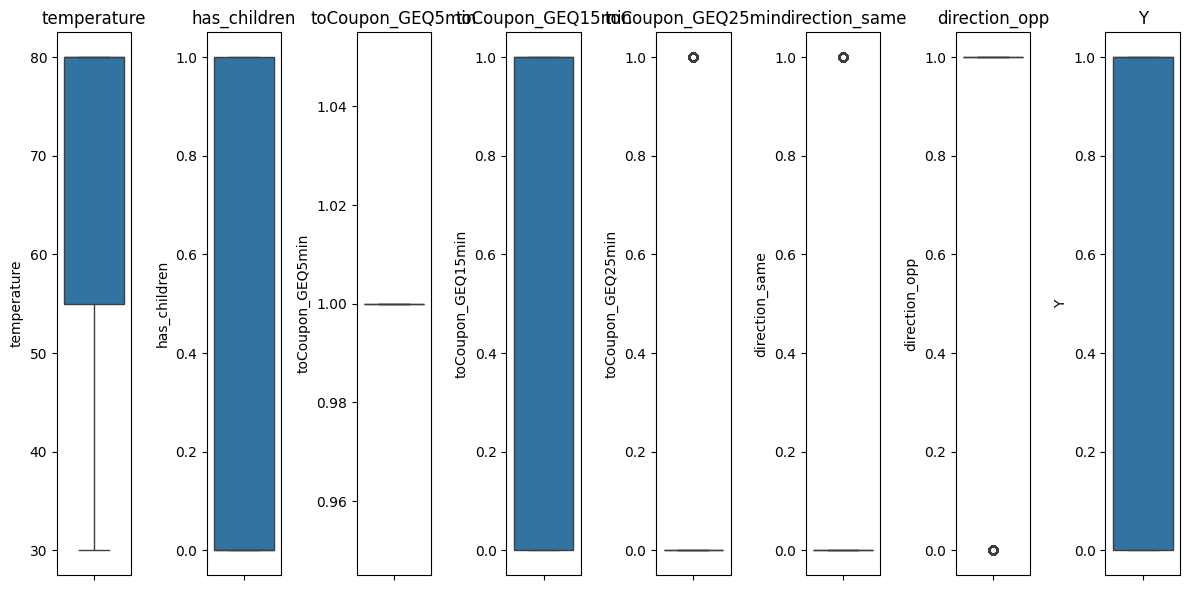

Outliers in temperature: 0
Outliers in has_children: 0
Outliers in toCoupon_GEQ5min: 0
Outliers in toCoupon_GEQ15min: 0
Outliers in toCoupon_GEQ25min: 1511
Outliers in direction_same: 2724
Outliers in direction_opp: 2724
Outliers in Y: 0


In [10]:

# Boxplots for numerical variables
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df_cleaned[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Statistical outlier detection
for col in num_cols:
    q1 = df_cleaned[col].quantile(0.25)
    q3 = df_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")

In [12]:
# Check for unusual categories in categorical variables
for col in cat_cols:
    value_counts = df_cleaned[col].value_counts(normalize=True)
    print(f"\nValue counts for {col}:")
    print(value_counts)
    
    # Identify rare categories (less than 1% of data)
    rare_categories = value_counts[value_counts < 0.01].index
    if len(rare_categories) > 0:
        print(f"Rare categories in {col}: {list(rare_categories)}")


Value counts for destination:
destination
No Urgent Place    0.495348
Home               0.255203
Work               0.249448
Name: proportion, dtype: float64

Value counts for passanger:
passanger
Alone        0.575922
Friend(s)    0.260013
Partner      0.084752
Kid(s)       0.079313
Name: proportion, dtype: float64

Value counts for weather:
weather
Sunny    0.793835
Snowy    0.110769
Rainy    0.095396
Name: proportion, dtype: float64

Value counts for time:
time
6PM     0.254652
7AM     0.249448
10AM    0.179360
2PM     0.158389
10PM    0.158152
Name: proportion, dtype: float64

Value counts for coupon:
coupon
Coffee House             0.315043
Restaurant(<20)          0.219647
Carry out & Take away    0.188663
Bar                      0.159019
Restaurant(20-50)        0.117629
Name: proportion, dtype: float64

Value counts for expiration:
expiration
1d    0.559051
2h    0.440949
Name: proportion, dtype: float64

Value counts for gender:
gender
Female    0.513324
Male      0.486676


In [13]:
# Examine unique values in categorical columns
categorical_cols = ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 
                   'gender', 'age', 'maritalStatus', 'has_children', 'education', 'occupation', 
                   'income', 'car']

print("Unique values in categorical columns:")
for col in categorical_cols:
    if col in df_cleaned.columns:
        unique_vals = df_cleaned[col].unique()
        print(f"\
{col} ({len(unique_vals)} unique values):")
        print(unique_vals)

Unique values in categorical columns:
destination (3 unique values):
['No Urgent Place' 'Home' 'Work']
passanger (4 unique values):
['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
weather (3 unique values):
['Sunny' 'Rainy' 'Snowy']
time (5 unique values):
['2PM' '10AM' '6PM' '7AM' '10PM']
coupon (5 unique values):
['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration (2 unique values):
['1d' '2h']
gender (2 unique values):
['Female' 'Male']
age (8 unique values):
['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalStatus (5 unique values):
['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
has_children (2 unique values):
[1 0]
education (6 unique values):
['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation (25 unique values):
['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Health